In [2]:
import open3d as o3d
import open3d.core as o3c
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
import copy
import scipy.sparse as sparse

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [46]:
def draw_registration_result_original_color(source, target, transformation):
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)
    
    source_array = np.asarray(source_temp.points)
    target_array = np.asarray(target.points)

    fig, ax = plt.subplots()
    ax.plot(source_array[:,0],source_array[:,1],'ro')
    ax.plot(target_array[:,0],target_array[:,1],'bo')
    ax.grid() 
    ax.set_aspect('equal')
    plt.show() 
    # o3d.visualization.draw_geometries([source_temp, target])

def vector_to_matrix(x):
    X = np.array([[np.cos(x[2]), -np.sin(x[2]), x[0]],
                [np.sin(x[2]), np.cos(x[2]), x[1]],
                [0, 0, 1]
                ])
    return X

def diff_vector(x_i, x_j):
    X_i = vector_to_matrix(x_i)
    X_j = vector_to_matrix(x_j)
    V_ij = np.dot(np.linalg.inv(X_i),X_j)
    return matrix_to_vector(V_ij)

def matrix_to_vector(X):
    x = np.array([X[0][2], X[1][2], math.atan2(X[1][0], X[0][0])]) 
    return x

def theta_to_rotation_matrix(theta):
    R = np.array([[np.cos(theta),   -np.sin(theta)],
                  [np.sin(theta),   np.cos(theta)]])
    return R

def theta_to_rotation_matrix_derivative(theta):
    R_derivative = np.array([[-np.sin(theta),   -np.cos(theta)],
                             [np.cos(theta),   -np.sin(theta)]])
    return R_derivative

def rotation_matrix_to_theta(R):
    theta = math.atan2(R[1][0], R[0][0])
    return theta


def ICP_init_guess(source_pos, target_pos):
    source_matrix = vector_to_matrix(source_pos)
    target_matrix = vector_to_matrix(target_pos)
    trans_matrix = np.dot(np.linalg.inv(target_matrix), source_matrix)
    return np.insert(np.insert(trans_matrix, 2, [0.0,0,0], axis=0), 2, [0.0,0,1,0], axis=1)


class Link:
    def __init__(self, infor_matrix, edge_vector, node_1, node_2):
        self.__infor_matrix = infor_matrix
        self.__edge_vector = edge_vector
        self.__node_1 = node_1
        self.__node_2 = node_2
        self.__A_ij = np.identity(3)
        self.__B_ij = np.identity(3)
        self.__error_vector = np.ones((1,3))

    def read_vector(self):
        return self.__edge_vector 

    def read_jacobi(self):
        matrix1 = np.dot(theta_to_rotation_matrix(self.__edge_vector[2]).T,
                         theta_to_rotation_matrix(self.__node_1.read_state()[2]).T)
        matrix2 = np.dot(theta_to_rotation_matrix(self.__edge_vector[2]).T, 
                         np.dot(theta_to_rotation_matrix_derivative(self.__node_1.read_state()[2]).T, 
                                self.__node_2.read_state()[:2]-self.__node_1.read_state()[:2]) )
        self.__A_ij = np.vstack( (np.hstack((-matrix1,matrix2.reshape(2,1))), np.array([0,0,-1.0])) )
        self.__B_ij = np.vstack( (np.hstack((matrix1,np.zeros((2,1)))), np.array([0,0,1.0])) )
        return(self.__A_ij, self.__B_ij)

    def read_error(self):
        error_matrix = np.dot(np.linalg.inv(vector_to_matrix(self.__edge_vector)), 
                              np.dot(np.linalg.inv(vector_to_matrix(self.__node_1.read_state())),
                                     vector_to_matrix(self.__node_2.read_state())))
        self.__error_vector = matrix_to_vector(error_matrix)
        return(self.__error_vector)

    def read_node_num(self):
        return (self.__node_1.read_num(), self.__node_2.read_num())
    
    def read_info(self):
        return self.__infor_matrix
    

    

class Node:
    def __init__(self, state_vector):
        self.__num = 0
        self.__state_vector = state_vector

    def resort(self, num):
        self.__num = num

    def read_state(self):
        return np.array(self.__state_vector)
    
    def set_state(self, state):
        self.__state_vector = state

    def read_num(self):
        return self.__num

In [79]:
with open('data/odom.pickle', 'rb') as handle:
    odom_data = pickle.load(handle)
with open('data/p3d.pickle', 'rb') as handle:
    p3d_data = pickle.load(handle)
with open('data/pc2.pickle', 'rb') as handle:
    pc2_data = pickle.load(handle)    

pcd = []
for pc2_pointcloud in pc2_data:
    o3d_pointcloud = o3d.geometry.PointCloud()
    o3d_pointcloud.points = o3d.utility.Vector3dVector(np.array(pc2_pointcloud))
    pcd.append(o3d_pointcloud)

In [80]:
pcd_copy = copy.deepcopy(pcd)
combined_pc = pcd_copy[0]
limit = 1

for i in range(len(pcd_copy)-limit):
    init_guess = ICP_init_guess(odom_data[i],odom_data[i+1])
    result_icp = o3d.pipelines.registration.registration_icp(
        pcd_copy[i], pcd_copy[i+1], 0.00001, init_guess,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    transformation = result_icp.transformation
    combined_pc = combined_pc.transform(transformation) + pcd_copy[i+1]
o3d.visualization.draw_geometries([combined_pc])

217


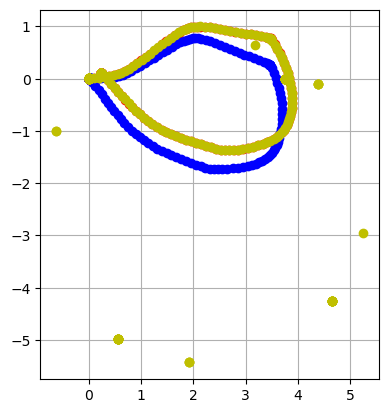

In [81]:
pcd_copy_2 = copy.deepcopy(pcd)
obv_coord  =[np.zeros((3))]
for i in range(len(pcd_copy_2)-limit):
    init_guess = ICP_init_guess(odom_data[i],odom_data[i+1])
    result_icp = o3d.pipelines.registration.registration_icp(
        pcd_copy_2[i], pcd_copy_2[i+1], 0.00001, init_guess,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    trans_matrix = np.linalg.inv(result_icp.transformation)
    trans_matrix_2d = np.delete(np.delete(trans_matrix,2,1), 2, 0)
    target_matrix = np.dot(vector_to_matrix(obv_coord[i]),trans_matrix_2d)
    target_vector = matrix_to_vector(target_matrix)
    obv_coord.append(target_vector)
print(len(obv_coord))
fig, ax = plt.subplots()

ax.plot(np.array(odom_data)[:len(pcd_copy_2)-limit,0],np.array(odom_data)[:len(pcd_copy_2)-limit,1],'ro')
ax.plot(np.array(p3d_data)[:len(pcd_copy_2)-limit,0],np.array(p3d_data)[:len(pcd_copy_2)-limit,1],'bo')
ax.plot(np.array(obv_coord)[:,0],np.array(obv_coord)[:,1],'yo')

ax.grid() 
ax.set_aspect('equal')
plt.show() 

In [86]:
Nodes = [Node(odom_data[0])]
Links = []

for i in range(len(odom_data)-1):
    Nodes.append(Node(odom_data[i+1]))
    Links.append(Link(np.identity(3)*0.01,diff_vector(Nodes[-2].read_state(),Nodes[-1].read_state()),Nodes[-2],Nodes[-1]))

    Links.append(Link(np.identity(3)*0.0001, diff_vector(obv_coord[i],odom_data[i+1]), Nodes[-2], Nodes[-1]))


for i in range(len(Nodes)):
    Nodes[i].resort(i)

node_num = int(len(Nodes))

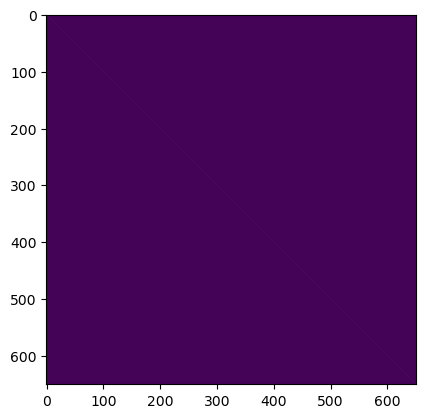

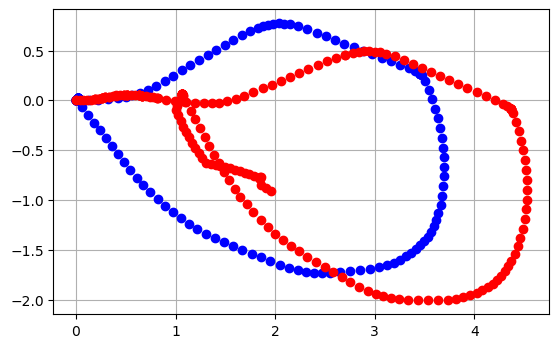

In [89]:
b = np.zeros(3*node_num)

H = np.zeros((3*node_num,3*node_num))


J = np.zeros((3,3*node_num))

X = np.zeros(3*node_num)

for node in Nodes:
    i = node.read_num()
    x = node.read_state()
    X[i*3:(i+1)*3] = X[i*3:(i+1)*3] + x

for link in Links:
    J_ij = np.zeros((3,3*node_num))
    A_ij, B_ij = link.read_jacobi()
    i,j = link.read_node_num()
    J_ij[:,i*3:(i+1)*3] = J_ij[:,i*3:(i+1)*3] + A_ij
    J_ij[:,j*3:(j+1)*3] = J_ij[:,j*3:(j+1)*3] + B_ij
    e_ij = link.read_error()
    omega_ij = link.read_info()

    b_ij = np.dot(J_ij.T, np.dot(omega_ij, e_ij))
    H_ij = np.dot(J_ij.T, np.dot(omega_ij,J_ij))


    H = H + H_ij
    b = b + b_ij
    
H[0:3,0:3] = H[0:3,0:3] + np.identity(3)

plt.imshow(H)
plt.show()

H=sparse.csc_matrix(H)
inv_H = sparse.linalg.inv(H).toarray()

delta_X = - np.dot(inv_H, b)

X = X + delta_X


for node in Nodes:
    i = node.read_num()
    node.set_state( X[i*3:(i+1)*3])

fig, ax = plt.subplots()
for pos in p3d_data:
    ax.plot(pos[0],pos[1],'bo')
for node in Nodes:
    state = node.read_state()
    ax.plot(state[0],state[1],'ro')

ax.grid() 
ax.set_aspect('equal')
plt.show() 
